In [1]:
from config import Config
import utils
import os 
import numpy as np
import json
import cv2
from keras import backend as K
from PIL import Image
from keras.preprocessing.image import *
import model as modellib
import random
import visualize
from visualize import display_images
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from model import log
%matplotlib

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Using matplotlib backend: TkAgg


Using TensorFlow backend.


In [2]:
# Root directory of the project
ROOT_DIR = os.getcwd()

MODEL_DIR = os.path.join(ROOT_DIR, "logs")

PLANT = "Sorghum"

MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_%s_trained.h5"% (PLANT))

LOAD_MODEL_PATH = os.path.join(ROOT_DIR, "logs/mask_rcnn_Sorghum_trained.h5")

In [3]:
class GroundTruth():
    
    def __init__(self, polyId, img_height, img_width):
        self.next = None
        self.mask = np.zeros((img_height,img_width), dtype = "uint8")
        self.max_x = 0
        self.max_y = 0
        self.min_x = 100000
        self.min_y = 100000
        self.p_Id = polyId
    
    def get_lists(self):
        
        maskList = []
        bboxList = []
        if(self.next == None):
            maskList.append(self.mask)
            bboxList.append(np.array([self.min_y, self.min_x, self.max_y, self.max_x]))
            return maskList, bboxList
        else:
            maskList, bboxList = self.next.get_lists()
            maskList.append(self.mask)
            bboxList.append(np.array([self.min_y, self.min_x, self.max_y, self.max_x]))
            return maskList, bboxList
    def __str__(self):
        
        temp = "____\nMax_x: " + str(self.max_x) + ", Min_x: " + str(self.min_x)
        temp = temp + "\n\nMax_y: " + str(self.max_y) + ", Min_y: " + str(self.min_y)

        return temp;

In [4]:
class StalkSpecConfig(Config):
    """Configuration for training on MS COCO.
    Derives from the base Config class and overrides values specific
    to the COCO dataset.
    """
    # Give the configuration a recognizable name
    NAME = "StalkSpec"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1

    # Uncomment to train on 8 GPUs (default is 1)
    # GPU_COUNT = 8

    # Number of classes (including background)
    NUM_CLASSES = 2  # Background and sorghum

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # Number of training steps per epoch
    # This doesn't need to match the size of the training set. Tensorboard
    # updates are saved at the end of each epoch, so setting this to a
    # smaller number means getting more frequent TensorBoard updates.
    # Validation stats are also calculated at each epoch end and they
    # might take a while, so don't set this too small to avoid spending
    # a lot of time on validation stats.
    STEPS_PER_EPOCH = 206

In [5]:
class StalkSpecDataset(utils.Dataset):
    
    """Load the dataset.
        dataset_dir: The root directory of the dataset.
        class_ids: If provided, only loads images that have the given classes.
    """
    def load_stalks(self, dataset_dir, data_id_file):
       
        self.add_class("stalk", 1, PLANT)
        # Path
        image_dir = os.path.join(dataset_dir, "images")
        train_path = os.path.join(dataset_dir, data_id_file)


        image_ids = []
        labels = []
        paths = []
        #fp = filePaths
        fp = open(train_path)
        lines = fp.readlines()
        fp.close()
        for line in lines:
            line = line.strip('\n')
            image_ids.append(int(line))
            json_file = open(dataset_dir + "/labels/%s.json"%(line))
            json_str = json_file.read()
            if(len(json_str) == 0): print(line)
            json_data = json.loads(json_str)
            labels.append(json_data)
            paths.append(line)
        pth = os.path.join(image_dir, "0003.jpg")
        img = cv2.imread(pth, 0)
        h = img.shape[0]
        w = img.shape[1]      
        for ix, i in enumerate(image_ids):
            self.add_image("stalk", image_id=i,
                           path=os.path.join(image_dir, "%s.jpg" % paths[ix]),
                           data_id_file=data_id_file,
                           data_dir = dataset_dir,
                           annotations = labels[ix],
                           height = h,
                           width = w)
        
    def load_mask(self, image_id):
        """Load instance masks for the given image.

        Different datasets use different ways to store masks. This
        function converts the different mask format to one format
        in the form of a bitmap [height, width, instances].

        Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        bboxes: array [num_instances, (y1, x1, y2, x2)].
        """
        image_info = self.image_info[image_id]
    
        json_data = image_info['annotations']

        img_scale = 5
        
        img_height = image_info['height']
        img_width = image_info['width']
        
        
        masks = []
        bboxes = []
        groundTruths = []

        

        for poly in json_data:
            polyId = poly['polygon_id']
            p = int(polyId)
            points = []
            currGt = None
            #find the ground truth        
            for gt in groundTruths:              
                if(gt.p_Id == p):
                    currGt = gt
                    break
            #if no ground truth was found make a new one and add it to the list
            if(currGt == None):
                currGt = GroundTruth(p, img_height, img_width)
                if(len(groundTruths) > 0):
                    groundTruths[len(groundTruths)-1].next = currGt
                groundTruths.append(currGt)
            #update the mask and the min/max x and y
            for vertex in poly['vertices']:
                x = int((int(vertex['x']) * img_scale)/2)
                y = int((int(vertex['y']) * img_scale)/2)
                points.append([x,y]) 
                if(x > currGt.max_x): currGt.max_x = x
                if(x < currGt.min_x): currGt.min_x = x
                if(y > currGt.max_y): currGt.max_y = y
                if(y < currGt.min_y): currGt.min_y = y
            points = np.array(points)
            mask = currGt.mask
            cv2.fillConvexPoly(mask, points, 255)
 
        masks, bboxs = groundTruths[0].get_lists()
        bboxs = np.asarray(bboxs)
        masks = np.asarray(masks)
        masks = np.swapaxes(masks, 0, 2)
        masks = np.swapaxes(masks, 0, 1)

        class_ids = []
        for i in range(0, masks.shape[2]):
            class_ids.append(1)
        
        class_ids = np.array(class_ids)

        return masks, class_ids.astype(np.int32), bboxs
    
        
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        
        if info["source"] == "plants":
            return info

In [6]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [7]:
inference_config = StalkSpecConfig()

debug_save_dir = "/media/default/ISAACTEGLER/maskrcnn/Mask_RCNN-2.0/debug/"
data_dir = "/media/default/ISAACTEGLER/data_sets/%s/squashed"%(PLANT)


dataset_test = StalkSpecDataset()
dataset_test.load_stalks(data_dir, "test.txt")
dataset_test.prepare()

model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

model_path = os.path.join(MODEL_DIR, "mask_rcnn_%s_trained.h5"%(PLANT))

In [8]:
model.load_weights(model_path, by_name=True)

/media/default/ISAACTEGLER/maskRcnn/Mask_Rcnn_configured/logs/mask_rcnn_Sorghum_trained.h5


7
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  512.00000
gt_class_id              shape: (8,)                  min:    1.00000  max:    1.00000
gt_bbox                  shape: (8, 4)                min:   16.00000  max:  381.00000
gt_mask                  shape: (512, 512, 8)         min:    0.00000  max:  255.00000


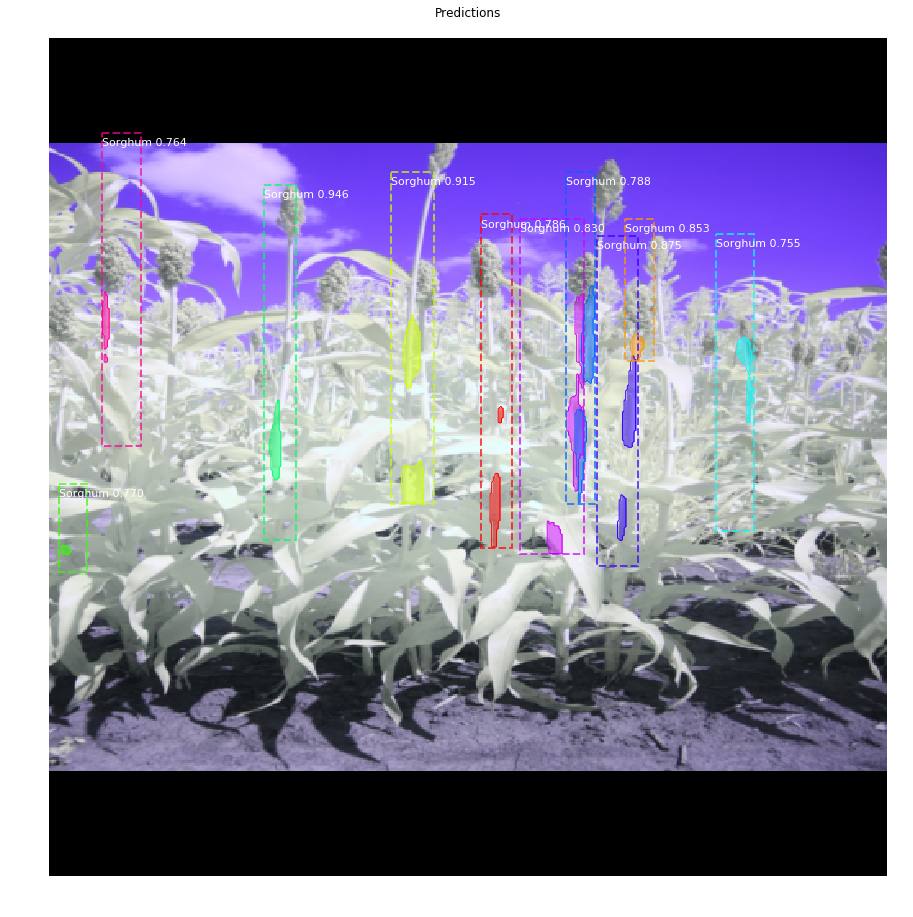

In [14]:
image_id = random.choice(dataset_test.image_ids)
print(image_id)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_test, inference_config, 
                           image_id, use_mini_mask=False)
results = model.detect([original_image], verbose=1)
ax = get_ax(1)
r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_test.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)